<a href="https://colab.research.google.com/github/aneeshcheriank/approaching-any-machine-learning-problem/blob/main/Gan_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[URL of this notebook](https://www.tensorflow.org/tutorials/generative/dcgan)

In [46]:
import tensorflow as tf
import glob # check
import imageio # check
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

from tensorflow.keras import layers
import time
from IPython import display

tf.config.run_functions_eagerly(True)

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = ((x_train - 127.5)/127.5)\
.reshape((-1, 28, 28, 1))

BUFFER_SIZE = 6000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)\
.shuffle(BUFFER_SIZE)\
.batch(BATCH_SIZE)

In [26]:
def make_generator_model():
  model = tf.keras.Sequential([
     layers.Dense(7*7*256, use_bias=False, input_shape=(100, )),
     layers.BatchNormalization(),
     layers.LeakyReLU(),

     layers.Reshape((7, 7, 256)),

     layers.Convolution2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
     layers.BatchNormalization(),
     layers.LeakyReLU(),
     # output size (None, 7, 7, 128)

     layers.Convolution2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
     layers.BatchNormalization(),
     layers.LeakyReLU(),
     # output size (None, 14, 14, 64)

     layers.Convolution2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])

  return model

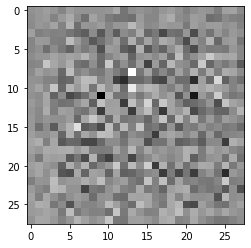

In [27]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generator_image = generator(noise, training=False)

plt.imshow(
    np.squeeze(generator_image), cmap='gray'
)

In [28]:
def make_discriminator_model():
  model = tf.keras.Sequential([
      layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(1)
  ])

  return model

In [29]:
discriminator = make_discriminator_model()
decision = discriminator(generator_image)
print(decision)

tf.Tensor([[0.00142935]], shape=(1, 1), dtype=float32)


In [44]:
# define the optimizer
# defind the loss
corss_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = corss_entropy(tf.ones_like(real_output), real_output)
  fake_loss = corss_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss
  # why should we do this? should we do the traditional way?

# generator loss
def generator_loss(fake_output):
  return corss_entropy(tf.ones_like(fake_output), fake_output)

- need to optimize the discriminator and the genetrator seperately
  - training is seperate

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [32]:
## Save Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [33]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [40]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [41]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## Generate and save images

In [42]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

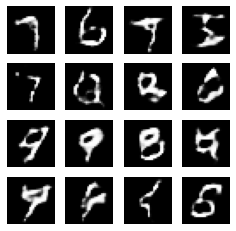

In [47]:
train(train_dataset, EPOCHS)
# Restore the checkpoints
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Create a GIF

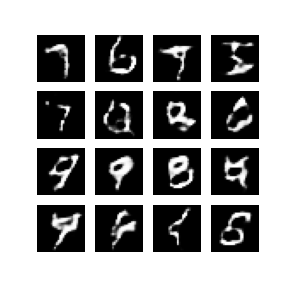

In [48]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

## Animated  GIF

In [51]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

# import tensorflow_docs.vis.embed as embed
# embed.embed_file(anim_file)